In [350]:
import sys
sys.path.append('../')

In [351]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from itertools import product
from torch.utils.data import DataLoader

from src.model import SindyModel
from src.main import get_args
from src.dataloader import ScrewdrivingDataset

In [352]:
%matplotlib inline
plt.ioff()

In [353]:
ARGS = get_args()

model_dir = os.path.join('..', 'out', 'sindy-model-out', 'checkpoints')
processed_model_dir = os.path.join('..', 'out', 'sindy-out-processed')
singal_data_dir = os.path.join('..', 'out', 'sindy-data')
out_dir = os.path.join('..', 'out', 'time-results')

os.makedirs(out_dir, exist_ok=True)

In [354]:
test_loader = DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))
test_x = torch.cat([batch[0] for batch in test_loader], dim=0)

test_y = [batch[1].numpy() for batch in DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))]
test_y = np.concatenate(test_y, axis=0)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[-1])

In [355]:
def signal_error(params, reference_signals, target_signals):
    adjusted_signals = adjust_signal(target_signals, *params)
    return np.sum((reference_signals[0] - adjusted_signals[0]) ** 2) + np.sum((reference_signals[1] - adjusted_signals[1]) ** 2)

def adjust_signal(target_signals, mean_adjustment, time_shift):
    return [
        adjust_signal_single(target_signals[0], mean_adjustment, time_shift),
        adjust_signal_single(target_signals[1], mean_adjustment, time_shift),
    ]
    
def adjust_signal_single(target_signal, mean_adjustment, time_shift):
    shifted_target_signal = np.interp(np.arange(len(target_signal)), np.arange(len(target_signal)) - time_shift, target_signal)
    return shifted_target_signal + mean_adjustment

In [356]:
def gen_pos_from_vel(start_pos, vel_x, vel_y):
    positions = [start_pos]
    x, y = start_pos
    time_period = 1 / 30  # seconds
    
    for t in range(segment_length - 1):
        x += np.real(vel_x[t]) * time_period
        y += np.real(vel_y[t]) * time_period
        positions.append((x, y))

    positions = np.array(positions)
    
    return [positions[:, 0], positions[:, 1]]

In [357]:
def check_circle_entry(positions, cc, cr):
    for idx, pos in enumerate(positions):
        distance = np.linalg.norm(pos - cc)
        # print(f'idx: {idx}, distance: {distance}')
        if distance <= cr:
            return idx
    return None

def generate_random_start(center, distance):
    angle = np.random.uniform(0, 2 * np.pi)
    x = center[0] + distance * np.cos(angle)
    y = center[1] + distance * np.sin(angle)
    return np.array([x, y])

In [358]:
model_params_df = pd.read_csv(os.path.join(processed_model_dir, 'cumulative_results.csv'))
segment_params_df = pd.read_csv(os.path.join(processed_model_dir, 'segmented', 'best_segmented_results.csv'))

model_names = model_params_df['model_name']

min_err = float('inf')
min_err_model = 'yo mama'

model_name = 'model_2024-05-10 21:22:16.041663.pth'
model_row = model_params_df[model_params_df.model_name == model_name].iloc[0]
segment_row = segment_params_df[segment_params_df.model_name == model_name].iloc[0]

segment_params = (segment_row.mean_adjustment, segment_row.time_shift)
full_x_params = (model_row.mean_adjustment_vx, model_row.time_shift_vx)
full_y_params = (model_row.mean_adjustment_vy, model_row.time_shift_vy)
ref_segment_start = segment_row.start_ref
target_segment_start = segment_row.start_target
segment_length = segment_row.segment_length


with torch.no_grad():
    model = SindyModel(**vars(ARGS))
    model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
    model.eval()
    
    pred_y = model(test_x).numpy()
    pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)
    
    reference_signal_x = np.copy(test_y)[:, 0]
    target_signal_x = pred_y[:, 0]
    adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)
    
    reference_signal_y = np.copy(test_y)[:, 1]
    target_signal_y = pred_y[:, 1]
    adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)
    
    best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)

    time_results = dict()
    circle_center = np.array([0, 0])
    circle_radius = 5
    top_rpm = 600
    rpm_levels = [top_rpm * frac for frac in [1.0, 0.9, 0.8]]
    
    for start_distance, rpm in product(range(5), rpm_levels):
        episode_results = []
        none_count = 0
        
        while len(episode_results) < 100:
            start_pos = generate_random_start(circle_center, start_distance + circle_radius)
            stacked_gen_pos = np.column_stack(gen_pos_from_vel(
                start_pos,
                best_segmented_vx[target_segment_start:target_segment_start + segment_length] * rpm / top_rpm,
                best_segmented_vy[target_segment_start:target_segment_start + segment_length] * rpm / top_rpm
            ))
            
            for idx in range(4):
                start_pos = stacked_gen_pos[-1]
                stacked_gen_pos = np.row_stack((
                    stacked_gen_pos, 
                    np.column_stack(gen_pos_from_vel(
                        start_pos,
                        best_segmented_vx[target_segment_start:target_segment_start + segment_length] * rpm / top_rpm,
                        best_segmented_vy[target_segment_start:target_segment_start + segment_length] * rpm / top_rpm
                        ))
                ))
            
            entry_time = check_circle_entry(stacked_gen_pos, circle_center, circle_radius)
            
            if entry_time is not None:
                episode_results.append(entry_time)
            else:
                none_count += 1
        
        if none_count > 1e9:
            time_results[(start_distance, rpm)] = [np.nan]
            break
        else:
            time_results[(start_distance, rpm)] = episode_results
    

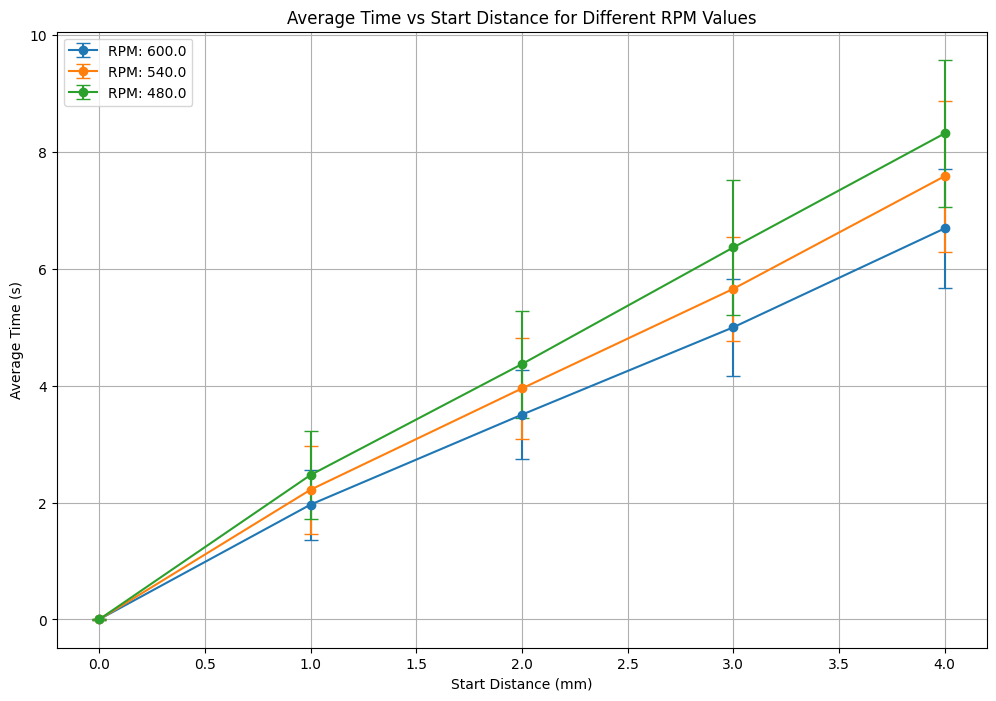

In [359]:
time_step_to_second_factor = 0.033301513000000005

start_distances = []
rpm_vals = []
avg_times = []
std_dev_times = []

for key, val in time_results.items():
    start_distances.append(key[0])
    rpm_vals.append(key[1])
    avg_times.append(np.average(val) * time_step_to_second_factor)
    std_dev_times.append(np.std(val) * time_step_to_second_factor)

df = pd.DataFrame({
    'Start Distance (mm)': start_distances,
    'RPM': rpm_vals,
    'Average Time (s)': avg_times,
    'Standard Deviation Time (s)': std_dev_times
})

unique_rpms = df['RPM'].unique()

plt.figure(figsize=(12, 8))

for rpm in unique_rpms:
    rpm_data = df[df['RPM'] == rpm]
    plt.errorbar(rpm_data['Start Distance (mm)'], rpm_data['Average Time (s)'],
                 yerr=rpm_data['Standard Deviation Time (s)'], fmt='o-', capsize=5,
                 label=f'RPM: {rpm}')

plt.xlabel('Start Distance (mm)')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Start Distance for Different RPM Values')
plt.grid(True)
plt.legend()

plt.show()

In [360]:
def plot_individual_rpm(rpm):
    rpm_data = df[df['RPM'] == rpm]
    plt.figure(figsize=(10, 6))
    plt.errorbar(rpm_data['Start Distance (mm)'], rpm_data['Average Time (s)'],
                 yerr=rpm_data['Standard Deviation Time (s)'], fmt='o-', capsize=5)
    plt.xlabel('Start Distance (mm)')
    plt.ylabel('Average Time (s)')
    plt.title(f'Average Time vs Start Distance for RPM: {rpm}')
    plt.grid(True)
    plt.ylim(-0.5, 10)
    plt.show()

In [361]:
unique_distances = sorted(df['Start Distance (mm)'].unique())

plt.figure(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(unique_rpms)))

df_sorted = df.sort_values(['RPM', 'Start Distance (mm)'])

<Figure size 1200x800 with 0 Axes>

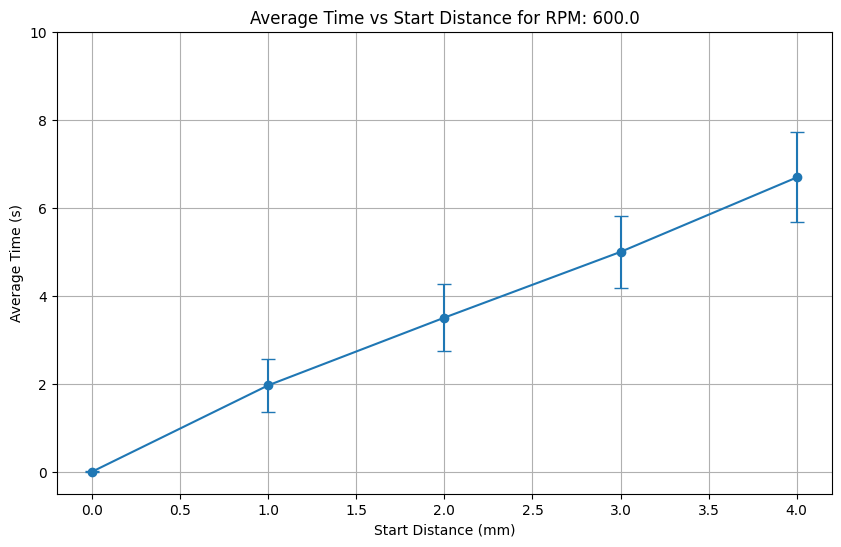

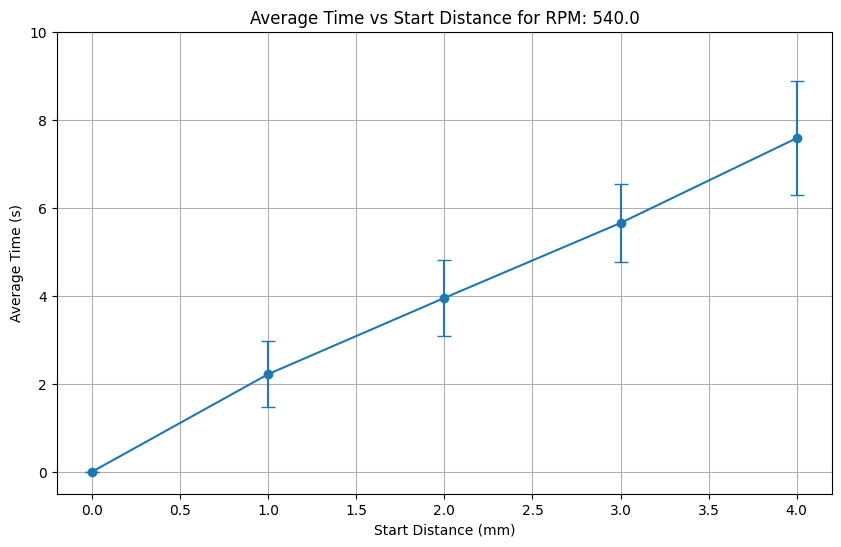

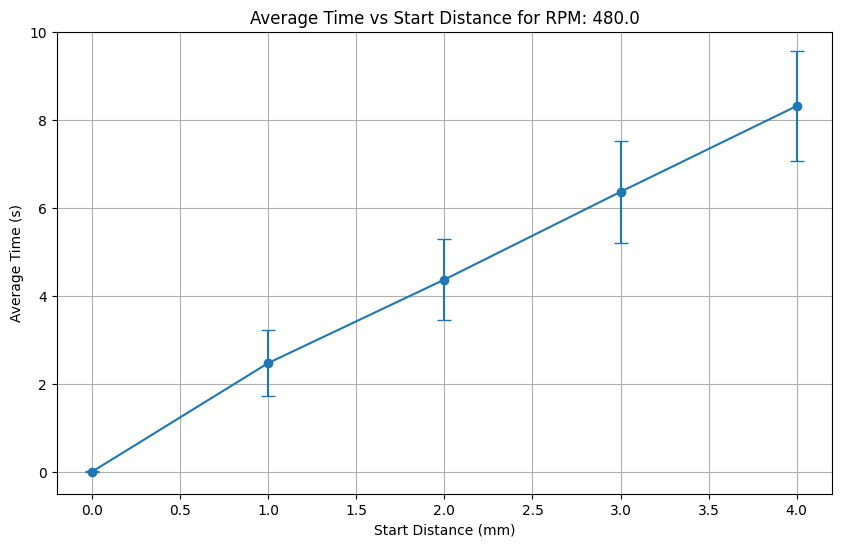

In [362]:
for rpm in unique_rpms:
    plot_individual_rpm(rpm)


Axis limits:
X-axis: (-0.2, 4.2)
Y-axis: (-0.4835397026714968, 10.051334878342956)


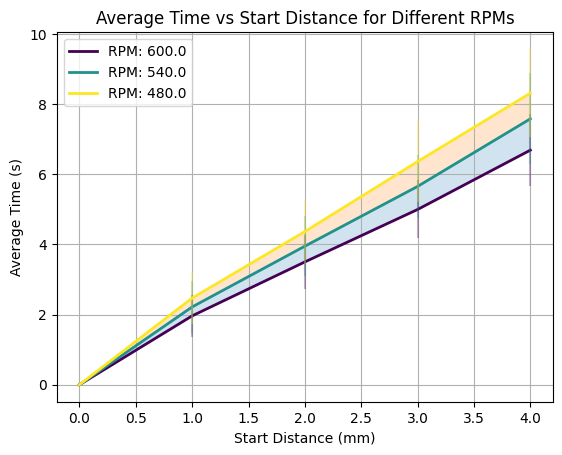

In [363]:
for i, rpm in enumerate(unique_rpms):
    rpm_data = df_sorted[df_sorted['RPM'] == rpm]
    if rpm_data.empty:
        print(f"No data for RPM: {rpm}")
        continue
    
    plt.plot(rpm_data['Start Distance (mm)'], rpm_data['Average Time (s)'], 
             color=colors[i], linewidth=2, label=f'RPM: {rpm}')

    plt.errorbar(rpm_data['Start Distance (mm)'], rpm_data['Average Time (s)'],
                 yerr=rpm_data['Standard Deviation Time (s)'],
                 fmt='none', ecolor=colors[i], alpha=0.3)

for i in range(len(unique_rpms) - 1):
    rpm1 = unique_rpms[i]
    rpm2 = unique_rpms[i+1]
    rpm1_data = df_sorted[df_sorted['RPM'] == rpm1]
    rpm2_data = df_sorted[df_sorted['RPM'] == rpm2]
    
    if not rpm1_data.empty and not rpm2_data.empty:
        plt.fill_between(rpm1_data['Start Distance (mm)'],
                         rpm1_data['Average Time (s)'],
                         rpm2_data['Average Time (s)'],
                         alpha=0.2)

plt.xlabel('Start Distance (mm)')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Start Distance for Different RPMs')
plt.grid(True)
plt.legend()

# Print the axis limits
print("\nAxis limits:")
print("X-axis:", plt.xlim())
print("Y-axis:", plt.ylim())

plt.show()

In [364]:
df

,Start Distance (mm),RPM,Average Time (s),Standard Deviation Time (s)
0,0,600.0,0.000999,0.005681
1,0,540.0,0.000333,0.003313
2,0,480.0,0.000999,0.005681
3,1,600.0,1.964123,0.598297
4,1,540.0,2.218547,0.750176
5,1,480.0,2.470639,0.746410
6,2,600.0,3.501987,0.760525
7,2,540.0,3.950225,0.864465
8,2,480.0,4.366827,0.914266
9,3,600.0,4.996226,0.826863
